# day 5

このノートブックの実行例は[こちら(HTML版)](../notebooks-sample/day-5.html)で確認できます

---

## 0. はじめに

ページ上部のメニューバーにある **Kernel** メニューをクリックし、プルダウンメニューから [**Change Kernel ...**] を選び、**gssm2023:Python** を選択してください。

<img src="images/change_kernel1.png" width="30%">

ノートブック上部の右隅に表示されたカーネル名が **gssm2023:Python** になっていることを確認してください。

<img src="images/change_kernel2.png" width="30%">

---

## 1. テキスト分析 (実践編)

### 1.0 事前準備

#### 1.0.1 関数の定義

以下のセルを**修正せず**に実行してください

In [1]:
import warnings
warnings.simplefilter('ignore')

import random
import numpy as np

# 乱数を固定する
seed = 42
random.seed(seed)
np.random.seed(seed)

# ワードクラウドを描画する
def plot_wordcloud(word_str, width=6, height=4):

    # 必要ライブラリのインポート
    import matplotlib.pyplot as plt

    # ノートブック中にプロットするマジックコマンド
    %matplotlib inline

    # プロットの準備
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(1, 1, 1)

    # 指定したプロット位置(ax)にワードクラウドを描画する
    plot_wordcloud_ax(ax, word_str)

    # プロットの仕上げ
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# 指定したプロット位置(ax)にワードクラウドを描画する
def plot_wordcloud_ax(ax, word_str):

    # フォントパスを取得する
    font_path = !find ${HOME} -name "ipaexg.ttf"

    # 必要ライブラリのインポート
    import wordcloud

    # ワードクラウドを作成する
    wc = wordcloud.WordCloud(
        background_color='white',
        font_path=font_path[0],
        max_font_size=100)

    # ワードクラウドを描画する
    img = wc.generate(word_str)
    ax.imshow(img, interpolation='bilinear')


# トピックモデルによるワードクラウドを描画する
def plot_topic_model(lda, feature_names, n_top_words=20, width=10, height=4):

    # フォントパスを取得する
    font_path = !find ${HOME} -name "ipaexg.ttf"

    # 必要ライブラリのインポート
    import matplotlib.pyplot as plt
    import wordcloud

    # ノートブック中にプロットするマジックコマンド
    %matplotlib inline

    fig = plt.figure(figsize=(width, height))

    # トピックごとのループ
    for topic_idx, topic in enumerate(lda.components_):

        # トピック中で出現確率の高い頻に単語をソートし,
        # ワードクラウドに描画するためテキストを生成する
        sorted_text = ' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]])

        # ワードクラウドを作成する
        wc = wordcloud.WordCloud(
            background_color='white',
            font_path=font_path[0],
            max_font_size=100)

        # プロット位置(ax)を選ぶ
        ax = fig.add_subplot(2, 3, topic_idx + 1)

        # ワードクラウドを描画する
        img = wc.generate(sorted_text)
        ax.imshow(img, interpolation='bilinear')
        ax.set_title(f"Topic # {topic_idx+1}:")

    # プロットの仕上げ
    plt.tight_layout()
    plt.show()


# 共起ネットワーク図を描画する (抽出語-抽出語用)
def plot_cooccur_network(df, word_counts, cutoff, width=8, height=8):

    # 必要ライブラリのインポート
    import matplotlib.pyplot as plt
    import japanize_matplotlib

    # プロットの準備
    plt.figure(figsize=(width, height))
    fig = plt.figure(figsize=(width, height))

    # プロット位置(ax)を選ぶ
    ax = fig.add_subplot(1, 1, 1)

    # 指定したプロット位置(ax)に共起ネットワーク図を描画する
    plot_cooccur_network_ax(ax, df, word_counts, cutoff)

    # プロットの仕上げ
    plt.axis("off")
    plt.show()

# 指定したプロット位置(ax)に共起ネットワーク図を描画する
def plot_cooccur_network_ax(ax, df, word_counts, cutoff):

    # 必要ライブラリのインポート
    import numpy as np
    import networkx as nx
    from networkx.algorithms import community
    from networkx.drawing.nx_agraph import graphviz_layout
    import matplotlib.pyplot as plt
    import japanize_matplotlib

    # ノートブック中にプロットするマジックコマンド
    %matplotlib inline

    # 共起行列の中身(numpy行列)を取り出す
    Xc = df.values

    # 共起行列中の最大値を求める
    Xc_max = Xc.max()

    # プロットする単語リストを取得する
    words = df.columns

    # プロットする単語の出現頻度の最大値を求める (正規化用)
    count_max = word_counts.max()

    weights_w, weights_c = [], []

    # 共起行列の要素ごとのループ (値がゼロの要素はスキップ)
    for i, j in zip(*Xc.nonzero()):
        # 対角行列でかつ値がしきい値を超えるものを保持する
        if i < j and Xc[i,j] > cutoff:
            # ノード: 一方の単語とノードの大きさ(正規化した出現頻度)を保持する
            weights_w.append((words[i], {'weight': word_counts[i] / count_max}))
            # ノード: 他方の単語とノードの大きさ(正規化した出現頻度)を保持する
            weights_w.append((words[j], {'weight': word_counts[j] / count_max}))
            # エッジ: 両端の単語を結ぶエッジの太さ(正規化した共起行列の値)を保持する
            weights_c.append((words[i], words[j], Xc[i,j] / Xc_max))

    # グラフの作成
    G = nx.Graph()
    G.add_nodes_from(weights_w)
    G.add_weighted_edges_from(weights_c)
    G.remove_nodes_from(list(nx.isolates(G)))
    # G = nx.minimum_spanning_tree(G)
    # pos = nx.spring_layout(G, k=0.3)
    pos = graphviz_layout(G, prog='neato', args='-Goverlap="scalexy" -Gsep="+6" -Gnodesep=0.8 -Gsplines="polyline" -GpackMode="graph" -Gstart={}'.format(43))

    # プロット用にノートとエッジの重みをリストに変換する
    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))

    # サブグラフの検出
    communities = community.greedy_modularity_communities(G)
    color_map = []
    for node in G:
        for i, c in enumerate(communities):
            if node in c:
                color_map.append(i)

    # グラフの描画
    nx.draw_networkx_nodes(G, pos, node_color=color_map, alpha=0.7, cmap=plt.cm.Set2, node_size=5000 * weights_n, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color='gray', edge_cmap=plt.cm.Blues, alpha=0.7, width=3 * weights_e, ax=ax)
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic', ax=ax)
    # ax.axis('off')


# 指定したプロット位置(ax)に共起ネットワーク図を描画する
def plot_cooccur_network_with_code_ax(ax, df, word_counts, cutoff, coding_rule=None):

    # 必要ライブラリのインポート
    import numpy as np
    import networkx as nx
    from networkx.algorithms import community
    from networkx.drawing.nx_agraph import graphviz_layout
    import matplotlib.pyplot as plt
    import japanize_matplotlib

    # ノートブック中にプロットするマジックコマンド
    %matplotlib inline

    # 共起行列の中身(numpy行列)を取り出す
    Xc = df.values

    # 共起行列中の最大値を求める
    Xc_max = Xc.max()

    # プロットする単語リストを取得する
    words = df.columns

    # プロットする単語の出現頻度の最大値を求める (正規化用)
    count_max = word_counts.max()

    weights_w, weights_c = [], []

    # 共起行列の要素ごとのループ (値がゼロの要素はスキップ)
    for i, j in zip(*Xc.nonzero()):
        # 対角行列でかつ値がしきい値を超えるものを保持する
        if i < j and Xc[i,j] > cutoff:
            # ノード: 一方の単語とノードの大きさ(正規化した出現頻度)を保持する
            weights_w.append((words[i], {'weight': word_counts[i] / count_max}))
            # ノード: 他方の単語とノードの大きさ(正規化した出現頻度)を保持する
            weights_w.append((words[j], {'weight': word_counts[j] / count_max}))
            # エッジ: 両端の単語を結ぶエッジの太さ(正規化した共起行列の値)を保持する
            weights_c.append((words[i], words[j], Xc[i,j] / Xc_max))

    # グラフの作成
    G = nx.Graph()
    G.add_nodes_from(weights_w)
    G.add_weighted_edges_from(weights_c)
    G.remove_nodes_from(list(nx.isolates(G)))
    # G = nx.minimum_spanning_tree(G)
    # pos = nx.spring_layout(G, k=0.3)
    pos = graphviz_layout(G, prog='neato', args='-Goverlap="scalexy" -Gsep="+6" -Gnodesep=0.8 -Gsplines="polyline" -GpackMode="graph" -Gstart={}'.format(43))

    # プロット用にノートとエッジの重みをリストに変換する
    nodelist_c = [node for node in G.nodes if node in coding_rule]
    nodelist_w = [node for node in G.nodes if node not in coding_rule]
    weights_c = np.array([G.nodes[node]['weight'] for node in G.nodes if node in coding_rule])
    weights_w = np.array([G.nodes[node]['weight'] for node in G.nodes if node not in coding_rule])
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))

    # サブグラフの検出
    communities = community.greedy_modularity_communities(G)
    color_map_c = []
    for node in G:
        if node in coding_rule:
            for i, c in enumerate(communities):
                if node in c:
                    color_map_c.append(i)
    color_map_w = []
    for node in G:
        if node not in coding_rule:
            for i, c in enumerate(communities):
                if node in c:
                    color_map_w.append(i)

    # グラフの描画
    nx.draw_networkx_nodes(G, pos, node_color=color_map_c, alpha=0.7, cmap=plt.cm.Set2, node_size=5000 * weights_c, ax=ax, nodelist=nodelist_c, node_shape='s', edgecolors='red')
    nx.draw_networkx_nodes(G, pos, node_color=color_map_w, alpha=0.7, cmap=plt.cm.Set2, node_size=5000 * weights_w, ax=ax, nodelist=nodelist_w)
    nx.draw_networkx_edges(G, pos, edge_color='gray', edge_cmap=plt.cm.Blues, alpha=0.7, width=3 * weights_e, ax=ax)
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic', ax=ax)
    # ax.axis('off')


# 共起ネットワークを描画する (外部変数-抽出語用)
def plot_attrs_network(df, attr_counts, word_counts, cutoff, width=8, height=8):

    # 必要ライブラリのインポート
    import numpy as np
    import networkx as nx
    import matplotlib.pyplot as plt
    import japanize_matplotlib
    from networkx.drawing.nx_agraph import graphviz_layout

    # ノートブック中にプロットするマジックコマンド
    %matplotlib inline

    # 共起行列の中身(numpy行列)を取り出す
    Xc = df.values

    # 共起行列中の最大値を求める
    Xc_max = Xc.max()

    # プロットする属性(外部変数等)リストを取得する
    attrs = list(df.index)

    # プロットする属性(外部変数等)の最大数を求める (正規化用)
    attr_count_max = attr_counts.max()

    # プロットする単語リストを取得する
    words = list(df.columns)

    # プロットする単語の出現頻度の最大値を求める (正規化用)
    word_count_max = word_counts.max()

    weights_n, weights_c = [], []

    # 共起行列の要素ごとのループ
    for i, j in zip(*Xc.nonzero()):
        # 値がしきい値を超えるものを保持する (値がゼロの要素はスキップ)
        if Xc[i,j] > cutoff:
            # ノード: 属性(外部変数等)とノードの大きさ(正規化した属性数)を保持する
            weights_n.append((attrs[i], {'weight': attr_counts[i] / attr_count_max, 'type': 'attr'}))
            # ノード: 単語とノードの大きさ(正規化した出現頻度)を保持する
            weights_n.append((words[j], {'weight': word_counts[j] / word_count_max, 'type': 'word'}))
            # エッジ: 属性(外部変数等)と単語を結ぶエッジの太さ(正規化した共起行列の値)を保持する
            weights_c.append((attrs[i], words[j], Xc[i,j] / Xc_max))

    # プロットの準備
    plt.figure(figsize=(width, height))

    # グラフの作成
    G = nx.Graph()
    G.add_nodes_from(weights_n)
    G.add_weighted_edges_from(weights_c)
    G.remove_nodes_from(list(nx.isolates(G)))
    # G = nx.minimum_spanning_tree(G)
    # pos = nx.spring_layout(G, k=0.3)
    pos = graphviz_layout(G, prog='neato', args='-Goverlap="scalexy" -Gsep="+6" -Gnodesep=0.8 -Gsplines="polyline" -GpackMode="graph" -Gstart={}'.format(43))

    # プロット用にノートとエッジの重みをリストに変換する
    nodelist_a = [node for node in G.nodes if G.nodes[node]['type'] == 'attr']
    nodelist_w = [node for node in G.nodes if G.nodes[node]['type'] == 'word']
    weights_a = np.array([G.nodes[node]['weight'] for node in G.nodes if G.nodes[node]['type'] == 'attr'])
    weights_w = np.array([G.nodes[node]['weight'] for node in G.nodes if G.nodes[node]['type'] == 'word'])
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))

    # 属性と単語を色分けする
    color_map = []
    for node in G:
        if G.nodes[node]['type'] == 'word':
            color_map.append(G.degree(node)+3)   # "+3"はカラーマップをシフトする調整値

    # グラフの描画
    nx.draw_networkx_nodes(G, pos, node_color='lightsalmon', alpha=0.7, cmap=plt.cm.Set2, node_size=1000 * weights_a, nodelist=nodelist_a, node_shape='s')
    nx.draw_networkx_nodes(G, pos, node_color=color_map, alpha=0.7, cmap=plt.cm.Set2, node_size=5000 * weights_w, nodelist=nodelist_w)
    nx.draw_networkx_edges(G, pos, edge_color='gray', edge_cmap=plt.cm.Blues, alpha=0.7, width=3 * weights_e)
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    # プロットの仕上げ
    plt.axis("off")
    plt.show()


# 係り受けによる共起ネットワークを描画する
def plot_dependency_network(df, word_counts, cutoff, width=8, height=8):

    # 必要ライブラリのインポート
    import numpy as np
    import networkx as nx
    from networkx.algorithms import community
    import matplotlib.pyplot as plt
    import japanize_matplotlib
    from networkx.drawing.nx_agraph import graphviz_layout

    # ノートブック中にプロットするマジックコマンド
    %matplotlib inline

    # 共起行列の中身(numpy行列)を取り出す
    Xc = df.values

    # 共起行列中の最大値を求める
    Xc_max = Xc.max()

    # プロットする単語リストを取得する
    words = df.columns

    # プロットする単語の出現頻度の最大値を求める (正規化用)
    count_max = word_counts.max()

    weights_w, weights_c = [], []

    # 共起行列の要素ごとのループ
    for i, j in zip(*Xc.nonzero()):
        # 対角行列でかつ値がしきい値を超えるものを保持する (値がゼロの要素はスキップ)
        if i != j and Xc[i,j] > cutoff:
            # ノード: 一方の単語とノードの大きさ(正規化した出現頻度)を保持する
            weights_w.append((words[i], {'weight': word_counts[i] / count_max}))
            # ノード: 他方の単語とノードの大きさ(正規化した出現頻度)を保持する
            weights_w.append((words[j], {'weight': word_counts[j] / count_max}))
            # エッジ: 両端の単語を結ぶエッジの太さ(正規化した共起行列の値)を保持する
            weights_c.append((words[i], words[j], Xc[i,j] / Xc_max))

    # プロットの準備
    plt.figure(figsize=(width, height))

    # グラフの作成
    G = nx.DiGraph()
    G.add_nodes_from(weights_w)
    G.add_weighted_edges_from(weights_c)
    G.remove_nodes_from(list(nx.isolates(G)))
    # G = nx.minimum_spanning_tree(G)
    # pos = nx.spring_layout(G, k=0.3)
    pos = graphviz_layout(G, prog='neato', args='-Goverlap="scalexy" -Gsep="+6" -Gnodesep=0.8 -Gsplines="polyline" -GpackMode="graph" -Gstart={}'.format(43))

    # プロット用にノートとエッジの重みをリストに変換する
    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))

    # サブグラフの検出
    communities = community.greedy_modularity_communities(G)
    color_map = []
    for node in G:
        for i, c in enumerate(communities):
            if node in c:
                color_map.append(i)

    # グラフの描画
    nx.draw_networkx_nodes(G, pos, node_color=color_map, alpha=0.7, cmap=plt.cm.Set2, node_size=5000 * weights_n)
    nx.draw_networkx_edges(G, pos, edge_color='gray', edge_cmap=plt.cm.Blues, alpha=0.7, width=3 * weights_e)
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    # プロットの仕上げ
    plt.axis("off")
    plt.show()


# 対応分析の結果をプロットする
def plot_coresp(row_coord, col_coord, row_labels, col_labels, explained_inertia=None, width=8, height=8):

    # 必要ライブラリのインポート
    import matplotlib.pyplot as plt
    import japanize_matplotlib

    # ノートブック中にプロットするマジックコマンド
    %matplotlib inline

    # プロットの準備
    # plt.figure(figsize=(width, height))

    # 行方向(外部変数)のプロット
    plt.plot(row_coord[:, 0], row_coord[:, 1], "*", color='red', alpha=0.5)
    for i, label in enumerate(row_labels):
        plt.text(row_coord[i, 0], row_coord[i, 1], label, color='red', ha='left', va='bottom')

    # 列方向(単語)のプロット
    plt.plot(col_coord[:, 0], col_coord[:, 1], "o", color='blue', alpha=0.5)
    for i, label in enumerate(col_labels):
        plt.text(col_coord[i, 0], col_coord[i, 1], label, color='blue', ha='left', va='bottom')

    # 原点を通る水平と垂直線を引く
    plt.axvline(0, linestyle='dashed', color='gray', alpha=0.5)
    plt.axhline(0, linestyle='dashed', color='gray', alpha=0.5)

    # 軸ラベルに寄与率を追記する
    if explained_inertia is not None:
        plt.xlabel(f"Dim 1 ({explained_inertia[0]:.3f}%)")
        plt.ylabel(f"Dim 2 ({explained_inertia[1]:.3f}%)")

    # プロットの仕上げ
    # plt.axis('equal')
    plt.show()


# PCA の結果をプロットする
def plot_pca(coeff, reduced, row_labels, col_labels, var_ratio=None, width=8, height=8):

    # 必要ライブラリのインポート
    import matplotlib.pyplot as plt
    import japanize_matplotlib

    # ノートブック中にプロットするマジックコマンド
    %matplotlib inline

    # プロットの準備
    # plt.figure(figsize=(width, height))

    # 行方向(外部変数)のプロット
    for i, label in enumerate(row_labels):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.5)
        plt.text(coeff[i, 0], coeff[i, 1], label, color='red', ha='left', va='bottom')

    # 列方向(単語)のプロット
    plt.plot(reduced[:, 0], reduced[:, 1], "o", color='blue', alpha=0.5)
    for i, label in enumerate(col_labels):
        plt.text(reduced[i, 0], reduced[i, 1], label, color='blue', ha='left', va='bottom')

    # 原点を通る水平と垂直線を引く
    plt.axvline(0, linestyle='dashed', color='gray', alpha=0.5)
    plt.axhline(0, linestyle='dashed', color='gray', alpha=0.5)

    # 軸ラベルに寄与率を追記する
    if var_ratio is not None:
        plt.xlabel(f"Dim 1 ({var_ratio[0]*100:.3f}%)")
        plt.ylabel(f"Dim 2 ({var_ratio[1]*100:.3f}%)")

    # プロットの仕上げ
    # plt.axis('equal')
    plt.show()


# 共起頻度行列を Jaccard 係数行列に変換する (抽出語-抽出語用)
def jaccard_coef(cooccur_df, cross_df):

    # 必要ライブラリのインポート
    import numpy as np
    import pandas as pd

    # 共起行列の中身(numpy行列)を取り出す
    Xc = cooccur_df.values

    # Jaccard 係数行列を初期化する (共起行列と同じ形)
    Xj = np.zeros(Xc.shape)

    # 単語ごとに共起度を集計する
    Xc_sum = cross_df.sum(axis=0).values

    # 共起行列の要素ごとのループ (値がゼロの要素はスキップ)
    for i, j in zip(*Xc.nonzero()):
        # 対角行列の要素を取り出す
        if i < j:
            # Jaccard 係数を求める
            Xj[i,j] = Xc[i,j] / (Xc_sum[i] + Xc_sum[j] - Xc[i,j])

    # DataFrame 型に整える
    jaccard_df = pd.DataFrame(Xj, columns=cooccur_df.columns, index=cooccur_df.columns)

    return jaccard_df


# 共起頻度行列を Jaccard 係数行列に変換する (外部変数-抽出語用)
def jaccard_attrs_coef(df, attr_counts, word_counts, total=10000, conditional=False):

    # 必要ライブラリのインポート
    import numpy as np
    import pandas as pd

    # 共起行列の中身(numpy行列)を取り出す
    Xc = df.values

    # Jaccard 係数行列を初期化する (共起行列と同じ形)
    Xj = np.zeros(df.shape)

    # 共起行列の要素ごとのループ (値がゼロの要素はスキップ)
    for i, j in zip(*Xc.nonzero()):

        # conditional フラグが True の場合, 条件付き確率 > 前提確率 以外はゼロにする
        if not conditional:

            # 条件付き確率を求める
            conditional_prob = Xc[i,j] / attr_counts[i]

            # 前提確率を求める
            assumption_prob = word_counts[j] / total

            # 条件付き確率 > 前提確率の場合
            if conditional_prob > assumption_prob:
                # Jaccard 係数を求める
                Xj[i,j] = Xc[i,j] / (attr_counts[i] + word_counts[j] - Xc[i,j])

            # 条件付き確率 <= 前提確率の場合
            else:
                # ゼロにする
                Xj[i,j] = .0

        # conditional フラグが False の場合, すべてのケースで Jaccard 係数を求める (デフォルト)
        else:
            # Jaccard 係数を求める
            Xj[i,j] = Xc[i,j] / (attr_counts[i] + word_counts[j] - Xc[i,j])

    # DataFrame 型に整える
    jaccard_df = pd.DataFrame(Xj, columns=df.columns, index=df.index)

    return jaccard_df

#### 1.0.1 データのダウンロード (前回ダウンロード済みのためスキップ)

以下のデータがダウンロード済みです

| ファイル名 | 件数 | データセット | 備考 |
| --- | --- | --- | --- |
| rakuten-1000-2022-2023.xlsx.zip | 10,000 | •レジャー+ビジネスの 10エリア<br>•エリアごと 1,000件 (ランダムサンプリング)<br>•期間: 2022/1~2023 GW明け | 本講義の全体を通して使用する |

In [2]:
# もし、再度ダウンロードが必要な場合は残りの行のコメントマーク「#」を除去して、このセルを再実行してください

# FILE_ID = "1n-uvGoH7XQhxexN57hYXuFrkGeHKp-HV"
# !gdown --id {FILE_ID}
# !unzip rakuten-1000-2022-2023.xlsx.zip

#### 1.0.2 データの読み込み (DataFrame型)

In [3]:
import numpy as np
import pandas as pd

all_df = pd.read_excel("rakuten-1000-2022-2023.xlsx")
print(all_df.shape)
display(all_df.head())

(10000, 18)


カテゴリー    エリア    施設番号                    施設名  \
0  A_レジャー  01_登別    5500                 登別　石水亭   
1  A_レジャー  01_登別   39175         登別温泉　登別グランドホテル   
2  A_レジャー  01_登別   20547       北湯沢温泉郷　湯元　ホロホロ山荘   
3  A_レジャー  01_登別  139962  ザ　レイクビュー　ＴＯＹＡ　乃の風リゾート   
4  A_レジャー  01_登別   80732       登別カルルス温泉　湯元オロフレ荘   

                                                コメント  総合  サービス  立地  部屋  \
0  お風呂が男女時間交代の屋上風呂に入れなかったのが残念でした。食事はスタッフの皆さんがとても親...   5     5   4   5   
1  大浴場のアメニティ、洗い場のクレンジング、ソープ、パック等が充実していて、大変良かったです。...   4     5   4   3   
2  犬プラン素泊まり一名で宿泊しましたが、夜8時頃売店でお土産(その時飲む飲み物など)を買う時に...   1     1   2   2   
3                                        部屋風呂が最高でした。   5     5   5   5   
4  カルルス温泉郷の静かな立地、そして湯元の素晴らしい泉質、美味しいお料理、飾らない中にも親切な...   5     5   5   5   

   設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月        投稿者   年代  性別  
0       5.0  4.0  5.0  レジャー  家族  44743   さとちん4359  60代  女性  
1       5.0  5.0  5.0  レジャー  家族  44835  まなちゃん5695  60代  女性  
2       3.0  4.0  NaN  レジャー  一人  44835        投稿者   na  na  
3       5.0  5.0  5.0  レジャー  恋人  44986        投稿者   na  na  
4       5.0  5.0  5.0  レジャー  家族  44986        投稿者   na  na

#### 1.0.3 「文書-抽出語」表 を作成する

コメント列から単語を抽出する (単語を品詞「名詞」「形容詞」「未知語」で絞り込む)

In [4]:
# 必要ライブラリのインポート
from collections import defaultdict
import MeCab

# mecab の初期化
tagger = MeCab.Tagger("-r ../tools/usr/local/etc/mecabrc --unk-feature 未知語")

# 単語頻度辞書の初期化
word_counts = defaultdict(lambda: 0)

# 抽出語情報リストの初期化
words = []

# 半角->全角変換マクロを定義する
ZEN = "".join(chr(0xff01 + i) for i in range(94))
HAN = "".join(chr(0x21 + i) for i in range(94))
HAN2ZEN = str.maketrans(HAN, ZEN)

# ストップワードを定義する
# stopwords = ['する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう']
stopwords = ["湯畑"]

# データ1行ごとのループ
for index, row in all_df.iterrows():

    # 半角->全角変換した後で, mecab で解析する
    node = tagger.parseToNode(row["コメント"].translate(HAN2ZEN))

    # 形態素ごとのループ
    while node:
        # 解析結果を要素ごとにバラす
        features = node.feature.split(',')

        # 品詞1 を取り出す
        pos1 = features[0]

        # 品詞2 を取り出す
        pos2 = features[1] if len(features) > 1 else ""

        # 原形 を取り出す
        base = features[6] if len(features) > 6 else None

        # 原型がストップワードに含まれない単語のみ抽出する
        if base not in stopwords:

            # 「名詞-一般」
            if (pos1 == "名詞" and pos2 == "一般"):
                base = base if base is not None else node.surface
                postag = "名詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容動詞」
            elif (pos1 == "名詞" and pos2 == "形容動詞語幹"):
                base = base if base is not None else node.surface
                base = f"{base}"
                postag = "形容動詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「形容詞」
            elif pos1 == "形容詞":
                base = base if base is not None else node.surface
                postag = "形容詞"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

            # 「未知語」
            elif pos1 == "未知語":
                base = base if base is not None else node.surface
                postag = "未知語"
                key = (base, postag)

                # 単語頻度辞書をカウントアップする
                word_counts[key] += 1

                # 抽出語情報をリストに追加する
                words.append([index + 1, base, postag, row["カテゴリー"], row["エリア"], key])

        # 次の形態素へ
        node = node.next

# DataFrme 型に整える
columns = [
    "文書ID",
    # "単語ID",
    "表層",
    "品詞",
    "カテゴリー",
    "エリア",
    "dict_key",
]
docs_df = pd.DataFrame(words, columns=columns)

# DataFrame を表示する
print(docs_df.shape)
display(docs_df.head())

(149372, 6)


文書ID  表層    品詞   カテゴリー    エリア    dict_key
0     1  風呂    名詞  A_レジャー  01_登別    (風呂, 名詞)
1     1  男女    名詞  A_レジャー  01_登別    (男女, 名詞)
2     1  屋上    名詞  A_レジャー  01_登別    (屋上, 名詞)
3     1  風呂    名詞  A_レジャー  01_登別    (風呂, 名詞)
4     1  残念  形容動詞  A_レジャー  01_登別  (残念, 形容動詞)

抽出語の出現頻度をカウントする

In [5]:
# 「文書-抽出語」 表から単語の出現回数をカウントする
word_list = []
for i, (k, v) in enumerate(sorted(word_counts.items(), key=lambda x:x[1], reverse=True)):
    word_list.append((i, k[0], v, k))

# DataFrame 型に整える
columns = [
    "単語ID",
    "表層",
    "出現頻度",
    "dict_key"
]

# DataFrame を表示する
word_counts_df = pd.DataFrame(word_list, columns=columns)
print(word_counts_df.shape)
display(word_counts_df.head(10))

(8390, 4)


単語ID    表層  出現頻度     dict_key
0     0    部屋  6689     (部屋, 名詞)
1     1    良い  5257    (良い, 形容詞)
2     2   ホテル  2831    (ホテル, 名詞)
3     3    風呂  2702     (風呂, 名詞)
4     4  美味しい  2249  (美味しい, 形容詞)
5     5    ない  2124    (ない, 形容詞)
6     6  スタッフ  1712   (スタッフ, 名詞)
7     7    温泉  1705     (温泉, 名詞)
8     8    よい  1446    (よい, 形容詞)
9     9    立地  1374     (立地, 名詞)

### 1.1 カテゴリーやエリアごとのユーザーの注目ポイントの評価の違いを見つける

#### 1.1.1 「文書-抽出語」表の作成

「文書-抽出語」表を作成する (出現回数 Top 1000語)

In [6]:
# 「単語出現回数」 表から出現回数Top 1000語のみ抽出する
word_counts_1000_df = word_counts_df[0:1000]

# 「文書-抽出語」 表も出現回数Top 150語のみに絞り込む
merged_df = pd.merge(docs_df, word_counts_1000_df, how="inner", on="dict_key", suffixes=["", "_right"])
docs_1000_df = merged_df[["文書ID", "単語ID", "表層", "品詞", "カテゴリー", "エリア", "dict_key"]]

# 「カテゴリー,エリア」でクロス集計する
cross_1000_df = pd.crosstab(
    [
        docs_1000_df['カテゴリー'], 
        docs_1000_df['エリア'], 
        docs_1000_df['文書ID']
    ],
    docs_1000_df['単語ID'], margins=False
)
cross_1000_df.columns = word_counts_1000_df["表層"]

「文書-抽出語」表を {0,1} に変換する

In [7]:
# 「文書-抽出語」 表を {0,1} に変換する
cross_1000_df[cross_1000_df > 0] = 1

# DataFrame を表示する
print(cross_1000_df.shape)
display(cross_1000_df)

(9879, 1000)


表層                  部屋  良い  ホテル  風呂  美味しい  ない  スタッフ  温泉  よい  立地  ...  長湯  \
カテゴリー  エリア   文書ID                                                ...       
A_レジャー 01_登別 1       0   0    0   1     1   0     1   0   0   0  ...   0   
             2       0   1    0   0     1   0     0   0   0   0  ...   0   
             3       1   1    0   0     0   1     0   1   0   0  ...   0   
             4       1   0    0   1     0   0     0   0   0   0  ...   0   
             5       0   0    0   0     1   0     0   0   0   1  ...   0   
...                 ..  ..  ...  ..   ...  ..   ...  ..  ..  ..  ...  ..   
B_ビジネス 10_福岡 9996    0   1    0   0     0   1     0   0   0   0  ...   0   
             9997    1   0    0   0     0   0     0   0   0   0  ...   0   
             9998    0   0    0   0     1   0     0   0   1   0  ...   0   
             9999    0   0    0   0     0   0     0   0   0   0  ...   0   
             10000   0   1    1   0     0   0     1   0   0   0  ...   0   

表層                  懐かしい  人柄  人達  アンケート  トータル  白  レンタカー  ダメ  スポット  
カテゴリー  エリア   文書ID                                                  
A_レジャー 01_登別 1         0   0   0      0     0  0      0   0     0  
             2         0   0   0      0     0  0      0   0     0  
             3         0   0   0      0     0  0      0   0     0  
             4         0   0   0      0     0  0      0   0     0  
             5         0   0   0      0     0  0      0   0     0  
...                  ...  ..  ..    ...   ... ..    ...  ..   ...  
B_ビジネス 10_福岡 9996      0   0   0      0     0  0      0   0     0  
             9997      0   0   0      0     0  0      0   0     0  
             9998      0   0   0      0     0  0      0   0     0  
             9999      0   0   0      0     0  0      0   0     0  
             10000     0   0   0      0     0  0      0   0     0  

[9879 rows x 1000 columns]

#### 1.1.2 共起行列を作成する (外部変数-抽出語)

In [8]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_df = pd.concat(
    [
        cross_1000_df.groupby(level='カテゴリー').sum(),
        cross_1000_df.groupby(level='エリア').sum()
    ]
)

# DataFrame を表示する
print(aggregate_df.shape)
display(aggregate_df)

(12, 1000)


表層        部屋    良い   ホテル    風呂  美味しい   ない  スタッフ    温泉   よい   立地  ...  長湯  \
A_レジャー  2398  2046   757  1535  1430  880   888  1188  631  518  ...  18   
B_ビジネス  2170  1655  1284   608   532  749   523   110  574  810  ...   1   
01_登別    447   409   194   323   255  187   148   222  114   38  ...   6   
02_草津    488   434   181   352   274  180   154   275  117  155  ...   4   
03_箱根    548   436   134   326   355  202   212   212  133   57  ...   4   
04_道後    416   349   191   181   174  130   135   225  137  176  ...   3   
05_湯布院   499   418    57   353   372  181   239   254  130   92  ...   1   
06_札幌    452   346   255   121   129  151   114    38  103  166  ...   0   
07_名古屋   434   310   241   116    97  144   102    18  133  141  ...   0   
08_東京    441   338   240   106    99  131    99    12  104  166  ...   0   
09_大阪    431   317   297   135    88  162    93    20  121  161  ...   1   
10_福岡    412   344   251   130   119  161   115    22  113  176  ...   0   

表層      懐かしい  人柄  人達  アンケート  トータル   白  レンタカー  ダメ  スポット  
A_レジャー    18  18  13      9     8  13      6  11    13  
B_ビジネス     1   1   6      6    11   4     13   8     6  
01_登別      4   1   3      3     3   2      1   1     1  
02_草津      7   8   4      3     2   2      1   2     1  
03_箱根      2   2   3      1     1   5      1   5     1  
04_道後      1   3   1      0     0   1      2   2     2  
05_湯布院     4   4   2      2     2   3      1   1     8  
06_札幌      0   1   1      1     2   0      7   4     1  
07_名古屋     0   0   1      2     0   2      1   1     1  
08_東京      0   0   2      0     1   1      0   0     1  
09_大阪      1   0   2      3     5   1      0   1     1  
10_福岡      0   0   0      0     3   0      5   2     2  

[12 rows x 1000 columns]

#### 1.1.3 Jaccard 係数を求める (外部変数-抽出語)

In [9]:
# 抽出語の出現回数を取得する
word_counts = cross_1000_df.sum(axis=0).values

# 属性(外部変数)出現数を取得する
attr_counts = np.hstack(
    [
        all_df.value_counts('カテゴリー').values,
        all_df.value_counts('エリア').values
    ]
)

# 共起行列の中身を Jaccard 係数に入れ替える
jaccard_attrs_df = jaccard_attrs_coef(aggregate_df, attr_counts, word_counts, total=10000, conditional=False)

# DataFrame を表示する
print(jaccard_attrs_df.shape)
display(jaccard_attrs_df)

(12, 1000)


表層            部屋        良い       ホテル        風呂      美味しい        ない      スタッフ  \
A_レジャー  0.334449  0.307438  0.000000  0.273716  0.258496  0.153070  0.160782   
B_ビジネス  0.000000  0.000000  0.223033  0.000000  0.000000  0.000000  0.000000   
01_登別   0.000000  0.095294  0.000000  0.114539  0.094200  0.076577  0.065400   
02_草津   0.096063  0.101711  0.000000  0.126120  0.101935  0.073499  0.068232   
03_箱根   0.109163  0.102227  0.000000  0.115726  0.136172  0.083230  0.096407   
04_道後   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
05_湯布院  0.098442  0.097595  0.000000  0.126523  0.143629  0.073938  0.110037   
06_札幌   0.000000  0.000000  0.091529  0.000000  0.000000  0.000000  0.000000   
07_名古屋  0.000000  0.000000  0.086071  0.000000  0.000000  0.000000  0.000000   
08_東京   0.000000  0.000000  0.085684  0.000000  0.000000  0.000000  0.000000   
09_大阪   0.000000  0.000000  0.108236  0.000000  0.000000  0.000000  0.000000   
10_福岡   0.000000  0.000000  0.089964  0.000000  0.000000  0.000000  0.000000   

表層            温泉        よい        立地  ...        長湯      懐かしい        人柄  \
A_レジャー  0.232485  0.113204  0.000000  ...  0.003599  0.003599  0.003599   
B_ビジネス  0.000000  0.000000  0.146792  ...  0.000000  0.000000  0.000000   
01_登別   0.106936  0.000000  0.000000  ...  0.005923  0.003941  0.000000   
02_草津   0.135937  0.000000  0.071330  ...  0.003941  0.006917  0.007913   
03_箱根   0.101630  0.064189  0.000000  ...  0.003941  0.001967  0.001967   
04_道後   0.108538  0.066248  0.081784  ...  0.002953  0.000000  0.002953   
05_湯布院  0.124266  0.062651  0.000000  ...  0.000000  0.003941  0.003941   
06_札幌   0.000000  0.000000  0.076781  ...  0.000000  0.000000  0.000000   
07_名古屋  0.000000  0.064189  0.064472  ...  0.000000  0.000000  0.000000   
08_東京   0.000000  0.000000  0.076781  ...  0.000000  0.000000  0.000000   
09_大阪   0.000000  0.058061  0.074296  ...  0.000000  0.000000  0.000000   
10_福岡   0.000000  0.000000  0.081784  ...  0.000000  0.000000  0.000000   

表層            人達     アンケート      トータル         白     レンタカー        ダメ      スポット  
A_レジャー  0.002597  0.001798  0.000000  0.002598  0.000000  0.002196  0.002597  
B_ビジネス  0.000000  0.000000  0.002196  0.000000  0.002597  0.000000  0.000000  
01_登別   0.002953  0.002964  0.002953  0.001970  0.000000  0.000000  0.000000  
02_草津   0.003941  0.002964  0.001967  0.001970  0.000000  0.001967  0.000000  
03_箱根   0.002953  0.000000  0.000000  0.004941  0.000000  0.004931  0.000000  
04_道後   0.000000  0.000000  0.000000  0.000000  0.001967  0.001967  0.001967  
05_湯布院  0.001967  0.001974  0.001967  0.002959  0.000000  0.000000  0.007913  
06_札幌   0.000000  0.000000  0.001967  0.000000  0.006917  0.003941  0.000000  
07_名古屋  0.000000  0.001974  0.000000  0.001970  0.000000  0.000000  0.000000  
08_東京   0.001967  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
09_大阪   0.001967  0.002964  0.004931  0.000000  0.000000  0.000000  0.000000  
10_福岡   0.000000  0.000000  0.002953  0.000000  0.004931  0.001967  0.001967  

[12 rows x 1000 columns]

#### 2.1.6 共起ネットワーク図

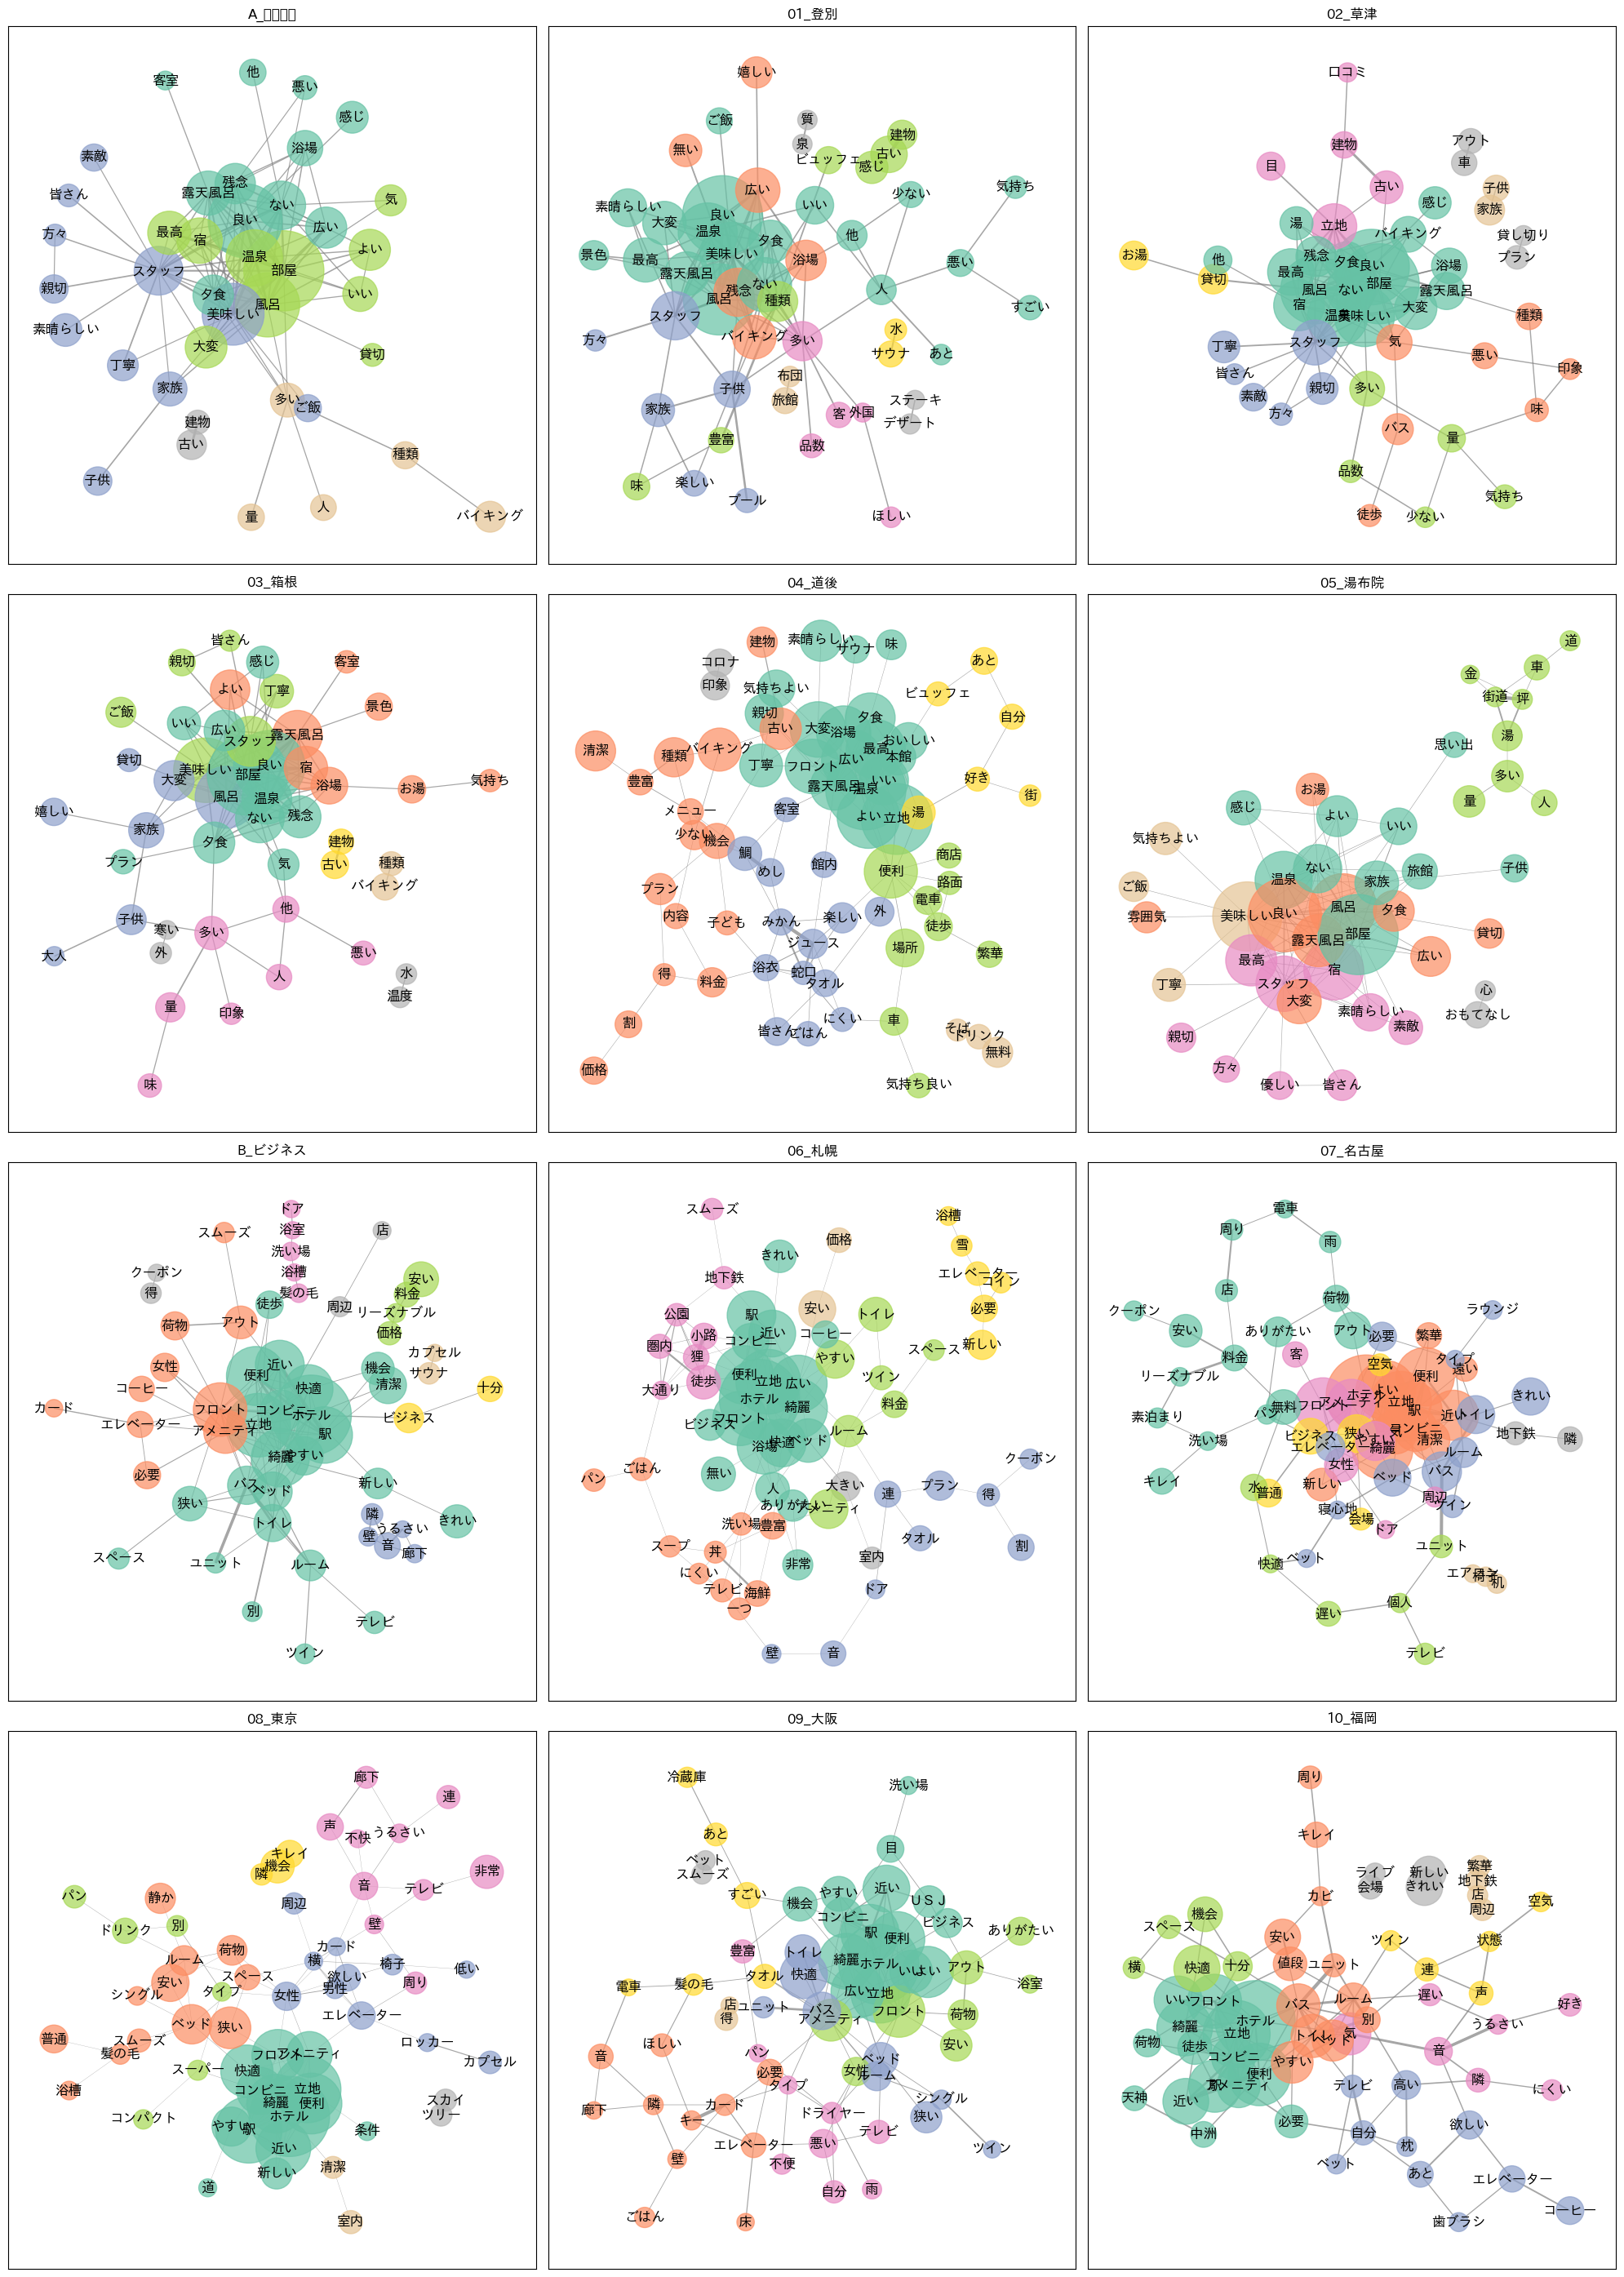

In [10]:
# 必要ライブラリのインポート
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# サブルーチン
def sort_and_plot(name, group):

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # 共起行列を作成する
    X = group_cross_df.values
    X = csc_matrix(X)
    Xc = (X.T * X)
    Xc = np.triu(Xc.toarray())

    # 共起行列を DataFrame に整える
    group_cooccur_df = pd.DataFrame(Xc, columns=group_cross_df.columns, index=group_cross_df.columns)

    # 共起行列の中身を Jaccard 係数に入れ替える
    group_jaccard_df = jaccard_coef(group_cooccur_df, group_cross_df)

    # 抽出語の出現回数を取得する
    word_counts = group_cross_df.sum(axis=0).values

    # プロットする
    ax = fig.add_subplot(4, 3, i+1)
    plot_cooccur_network_ax(ax, group_jaccard_df, word_counts, np.sort(group_jaccard_df.values.reshape(-1))[::-1][120])
    ax.set_title(name)


# プロットの準備
fig = plt.figure(figsize=(20, 28))

i = 0
# カテゴリごとのループ
for name, group in cross_1000_df.groupby(level='カテゴリー'):
    # サブルーチンを呼ぶ
    sort_and_plot(name, group)
    i += 1

    # エリアごとのループ
    for sub_name, sub_group in group.groupby(level='エリア'):
        # サブルーチンを呼ぶ
        sort_and_plot(sub_name, sub_group)
        i += 1

# プロットの仕上げ
plt.tight_layout()
plt.show()

### 1.2 高評価のエリアに倣って、低評価のエリアを改善するプランを提案する

#### 1.2.0 対照的な2エリアを選択する

In [11]:
# コーディングルール
coding_pos = ["良い","美味しい","広い","多い","素晴らしい","嬉しい","気持ちよい","楽しい","近い","大きい","気持ち良い","温かい","早い","優しい","新しい","暖かい","快い","明るい","美しい","可愛い","満足"]
coding_neg = ["古い","無い","高い","悪い","小さい","狭い","少ない","寒い","遅い","熱い","欲しい","暑い","冷たい","遠い","臭い","暗い","うるさい","ない","無い","残念","改善","不満"]

In [12]:
# DataFrame を初期化する
cross_1000_ps_df = cross_1000_df.copy()
cross_1000_ps_df['ポジ'] = 0
cross_1000_ps_df['ネガ'] = 0
cross_1000_ps_df['総合1-2'] = 0
cross_1000_ps_df['総合4-5'] = 0

# コーディングルールを適用する (ポジ・ネガ)
pos_index = docs_df['表層'].str.contains("|".join(coding_pos))
neg_index = docs_df['表層'].str.contains("|".join(coding_neg))
cross_1000_ps_df.loc[cross_1000_ps_df.index.get_level_values('文書ID').isin(docs_df.loc[pos_index, '文書ID']), 'ポジ'] = 1
cross_1000_ps_df.loc[cross_1000_ps_df.index.get_level_values('文書ID').isin(docs_df.loc[neg_index, '文書ID']), 'ネガ'] = 1

# コーディングルールを適用する (総合評価)
cross_1000_ps_df.loc[cross_1000_ps_df.index.get_level_values('文書ID').isin(all_df[all_df['総合'] <=2].index), '総合1-2'] = 1
cross_1000_ps_df.loc[cross_1000_ps_df.index.get_level_values('文書ID').isin(all_df[all_df['総合'] >=4].index), '総合4-5'] = 1
cross_1000_ps_df = cross_1000_ps_df[['ポジ','ネガ','総合1-2','総合4-5']]

# DataFrame を表示する
print(cross_1000_ps_df.shape)
display(cross_1000_ps_df)

(9879, 4)


表層                  ポジ  ネガ  総合1-2  総合4-5
カテゴリー  エリア   文書ID                       
A_レジャー 01_登別 1       1   1      0      1
             2       1   0      1      0
             3       1   1      0      1
             4       0   0      0      1
             5       1   0      0      1
...                 ..  ..    ...    ...
B_ビジネス 10_福岡 9996    1   1      0      1
             9997    1   1      0      1
             9998    1   0      1      0
             9999    0   1      0      1
             10000   1   1      0      0

[9879 rows x 4 columns]

In [13]:
# 「カテゴリー」のクロス集計と「エリア」のクロス集計を連結する
aggregate_ps_df = pd.concat(
    [
        cross_1000_ps_df.groupby(level='カテゴリー').sum(),
        cross_1000_ps_df.groupby(level='エリア').sum()
    ]
)

# DataFrame を表示する
print(aggregate_ps_df.shape)
display(aggregate_ps_df)

(12, 4)


表層        ポジ    ネガ  総合1-2  総合4-5
A_レジャー  3715  2212    299   4218
B_ビジネス  3036  1921    276   4105
01_登別    720   486     81    798
02_草津    756   464     64    830
03_箱根    772   489     72    839
04_道後    670   369     49    844
05_湯布院   797   404     33    907
06_札幌    633   388     60    826
07_名古屋   590   375     55    822
08_東京    601   372     63    811
09_大阪    582   389     52    833
10_福岡    630   397     46    813

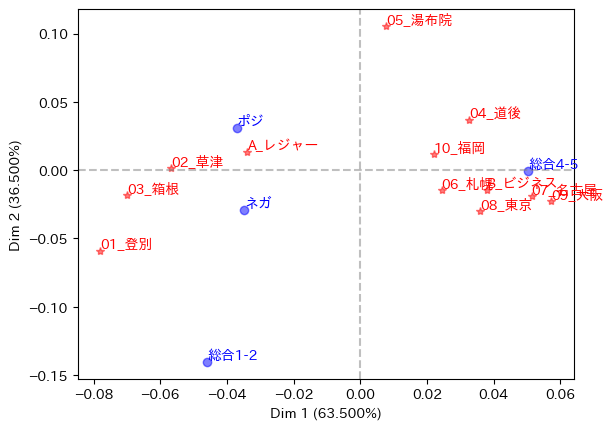

In [14]:
# 必要ライブラリのインポート
import mca

# ライブラリ mca による対応分析
ncols = aggregate_ps_df.shape[1]
mca_ben = mca.MCA(aggregate_ps_df, ncols=ncols, benzecri=False)

# 行方向および列方向の値を取り出す
row_coord = mca_ben.fs_r(N=2)
col_coord = mca_ben.fs_c(N=2)

# 固有値を求める
eigenvalues = mca_ben.L
total = np.sum(eigenvalues)
# 寄与率を求める
explained_inertia = 100 * eigenvalues / total

# 行方向および列方向のラベルを取得する
row_labels = aggregate_ps_df.index
col_labels = aggregate_ps_df.columns

# プロットする
plot_coresp(row_coord, col_coord, row_labels, col_labels, explained_inertia)

#### 1.2.1 ポジティブ意見の「文書-抽出語」表を作成する

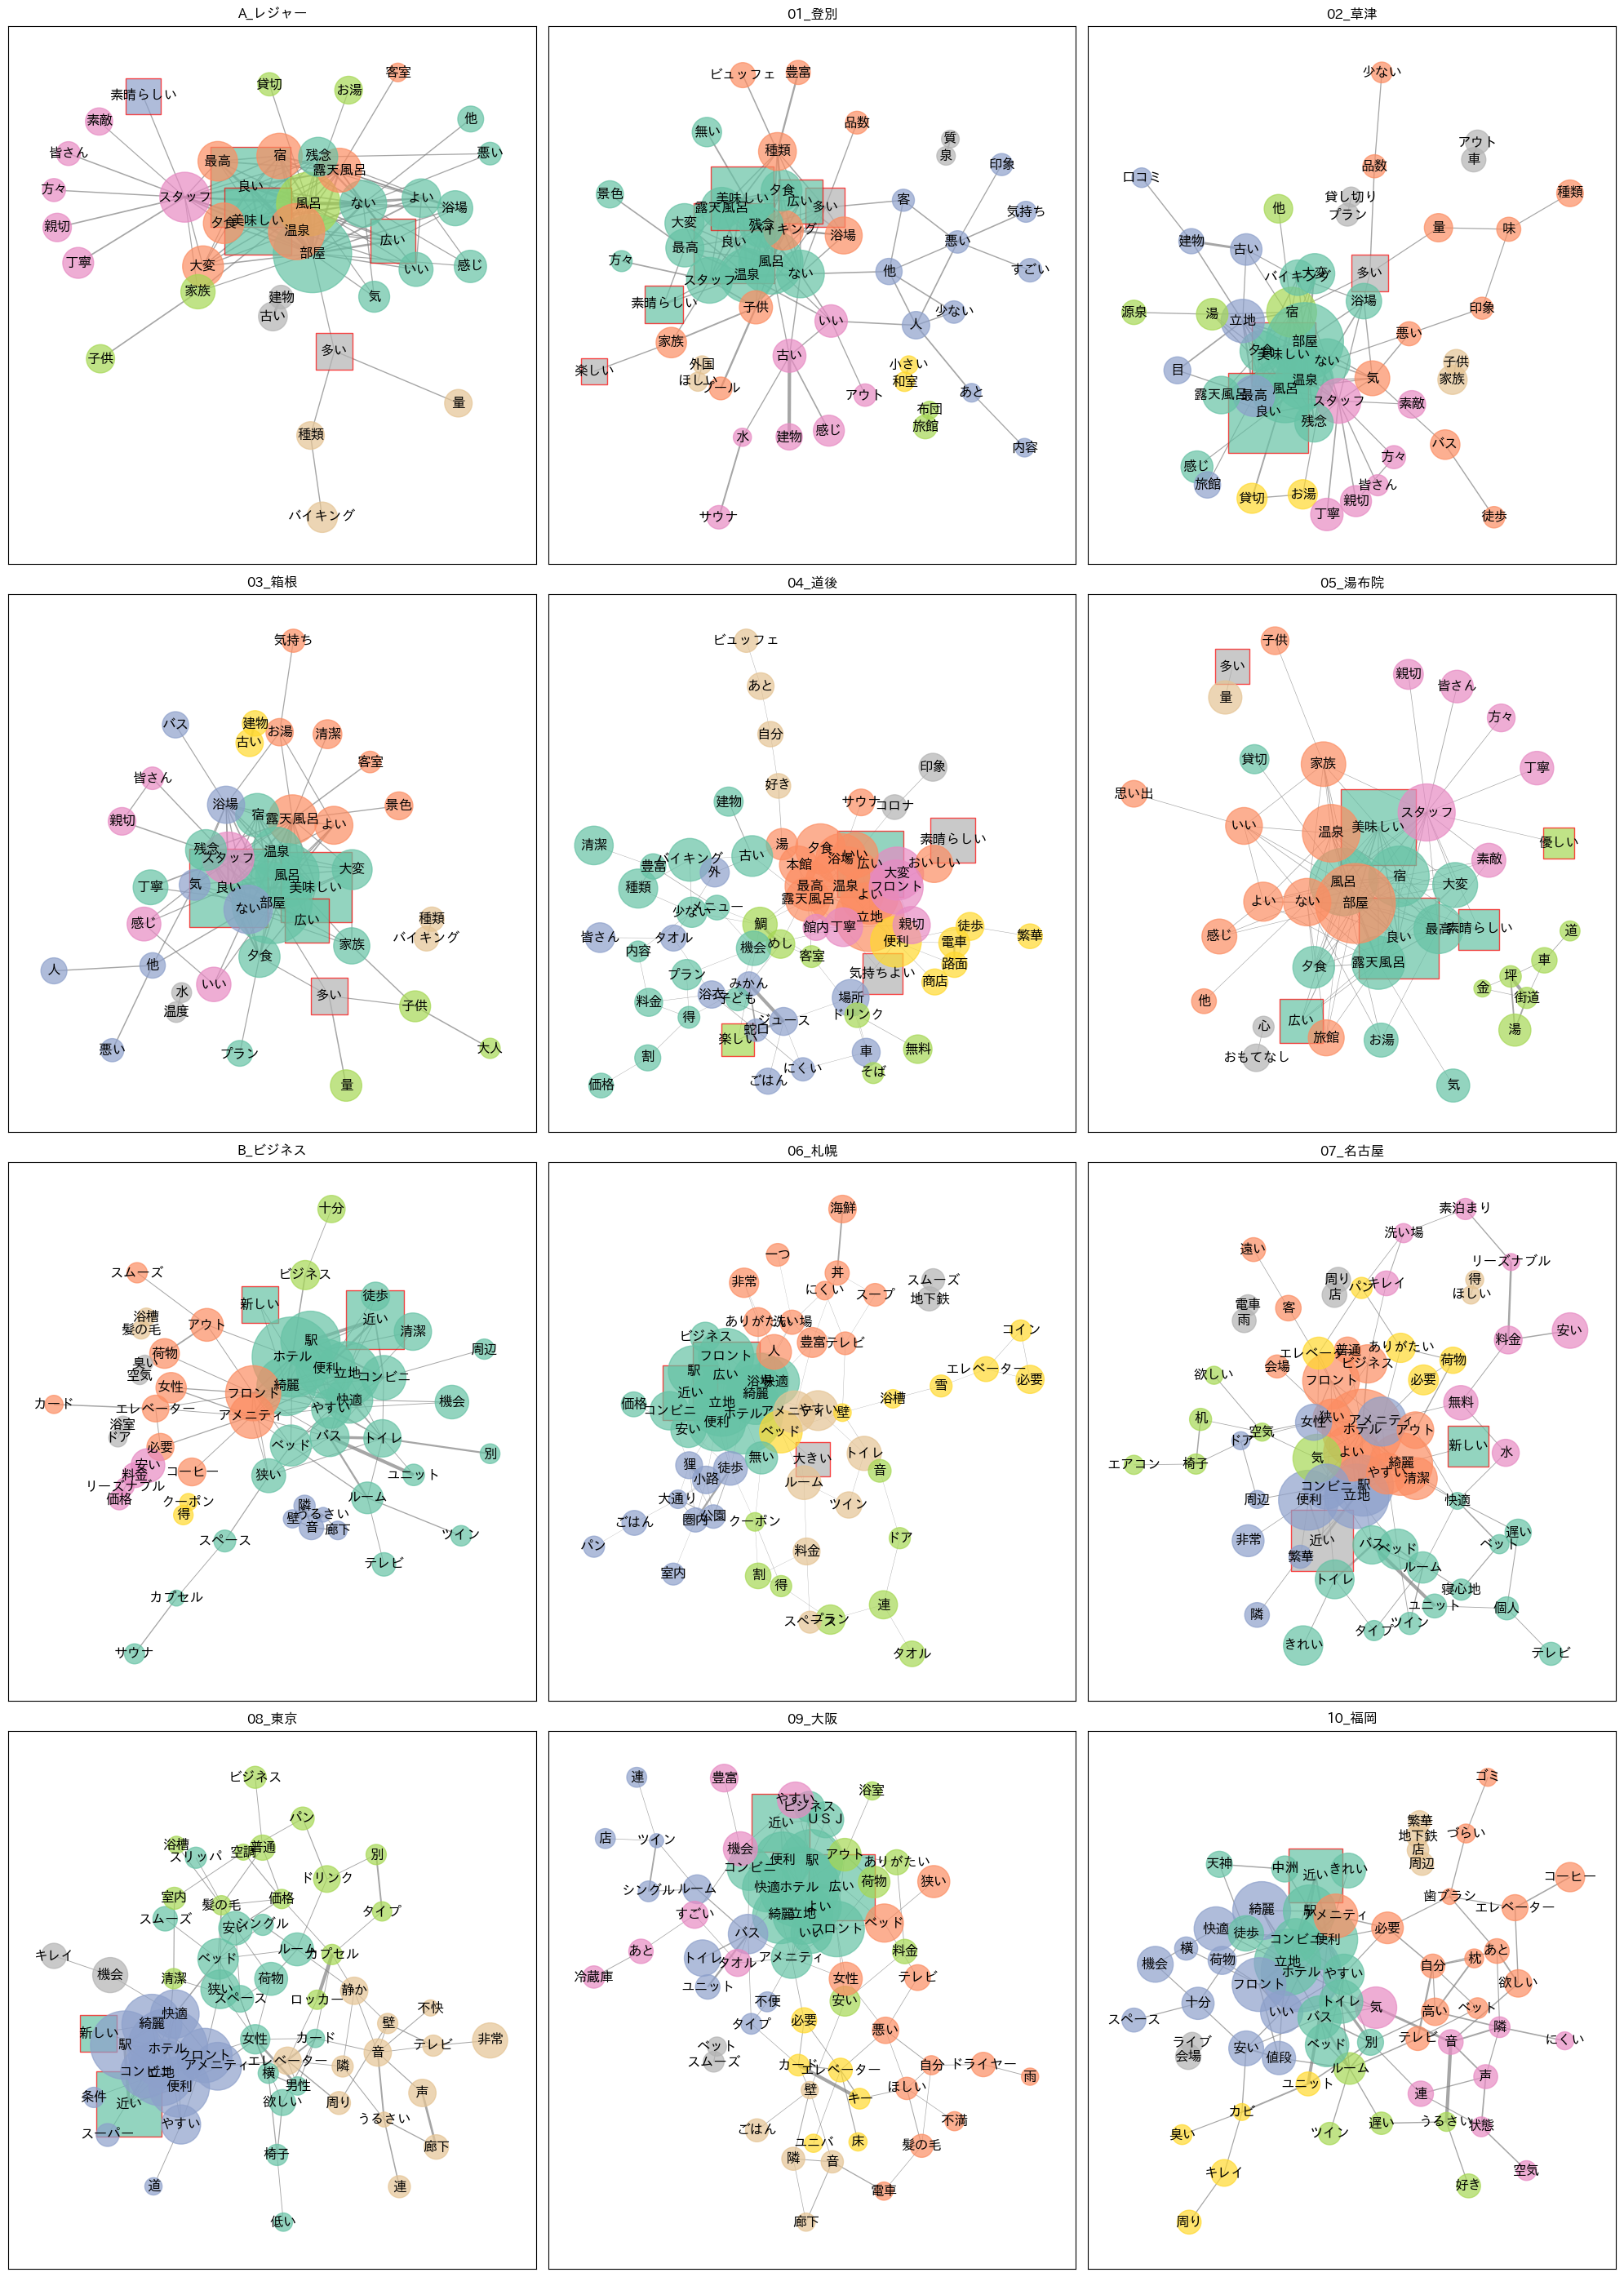

In [15]:
# 必要ライブラリのインポート
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# コーディングルール
coding_or = coding_pos

# サブルーチン
def sort_and_plot(name, group):

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # 共起行列を作成する
    X = group_cross_df.values
    X = csc_matrix(X)
    Xc = (X.T * X)
    Xc = np.triu(Xc.toarray())

    # コーディングルールで絞り込む
    index = docs_df['表層'].str.contains("|".join(coding_or))
    group_cross_df = group_cross_df[group_cross_df.index.get_level_values('文書ID').isin(docs_df.loc[index, '文書ID'])]

    # 共起行列を DataFrame に整える
    group_cooccur_df = pd.DataFrame(Xc, columns=group_cross_df.columns, index=group_cross_df.columns)

    # 共起行列の中身を Jaccard 係数に入れ替える
    group_jaccard_df = jaccard_coef(group_cooccur_df, group_cross_df)

    # 抽出語の出現回数を取得する
    word_counts = group_cross_df.sum(axis=0).values

    # プロットする
    ax = fig.add_subplot(4, 3, i+1)
    plot_cooccur_network_with_code_ax(ax, group_jaccard_df, word_counts, np.sort(group_jaccard_df.values.reshape(-1))[::-1][120], coding_or)
    ax.set_title(name)


# プロットの準備
fig = plt.figure(figsize=(20, 28))

i = 0
# カテゴリごとのループ
for name, group in cross_1000_df.groupby(level='カテゴリー'):
    # サブルーチンを呼ぶ
    sort_and_plot(name, group)
    i += 1

    # エリアごとのループ
    for sub_name, sub_group in group.groupby(level='エリア'):
        # サブルーチンを呼ぶ
        sort_and_plot(sub_name, sub_group)
        i += 1

# プロットの仕上げ
plt.tight_layout()
plt.show()

#### 1.2.2 ネガティブ意見の「文書-抽出語」表を作成する

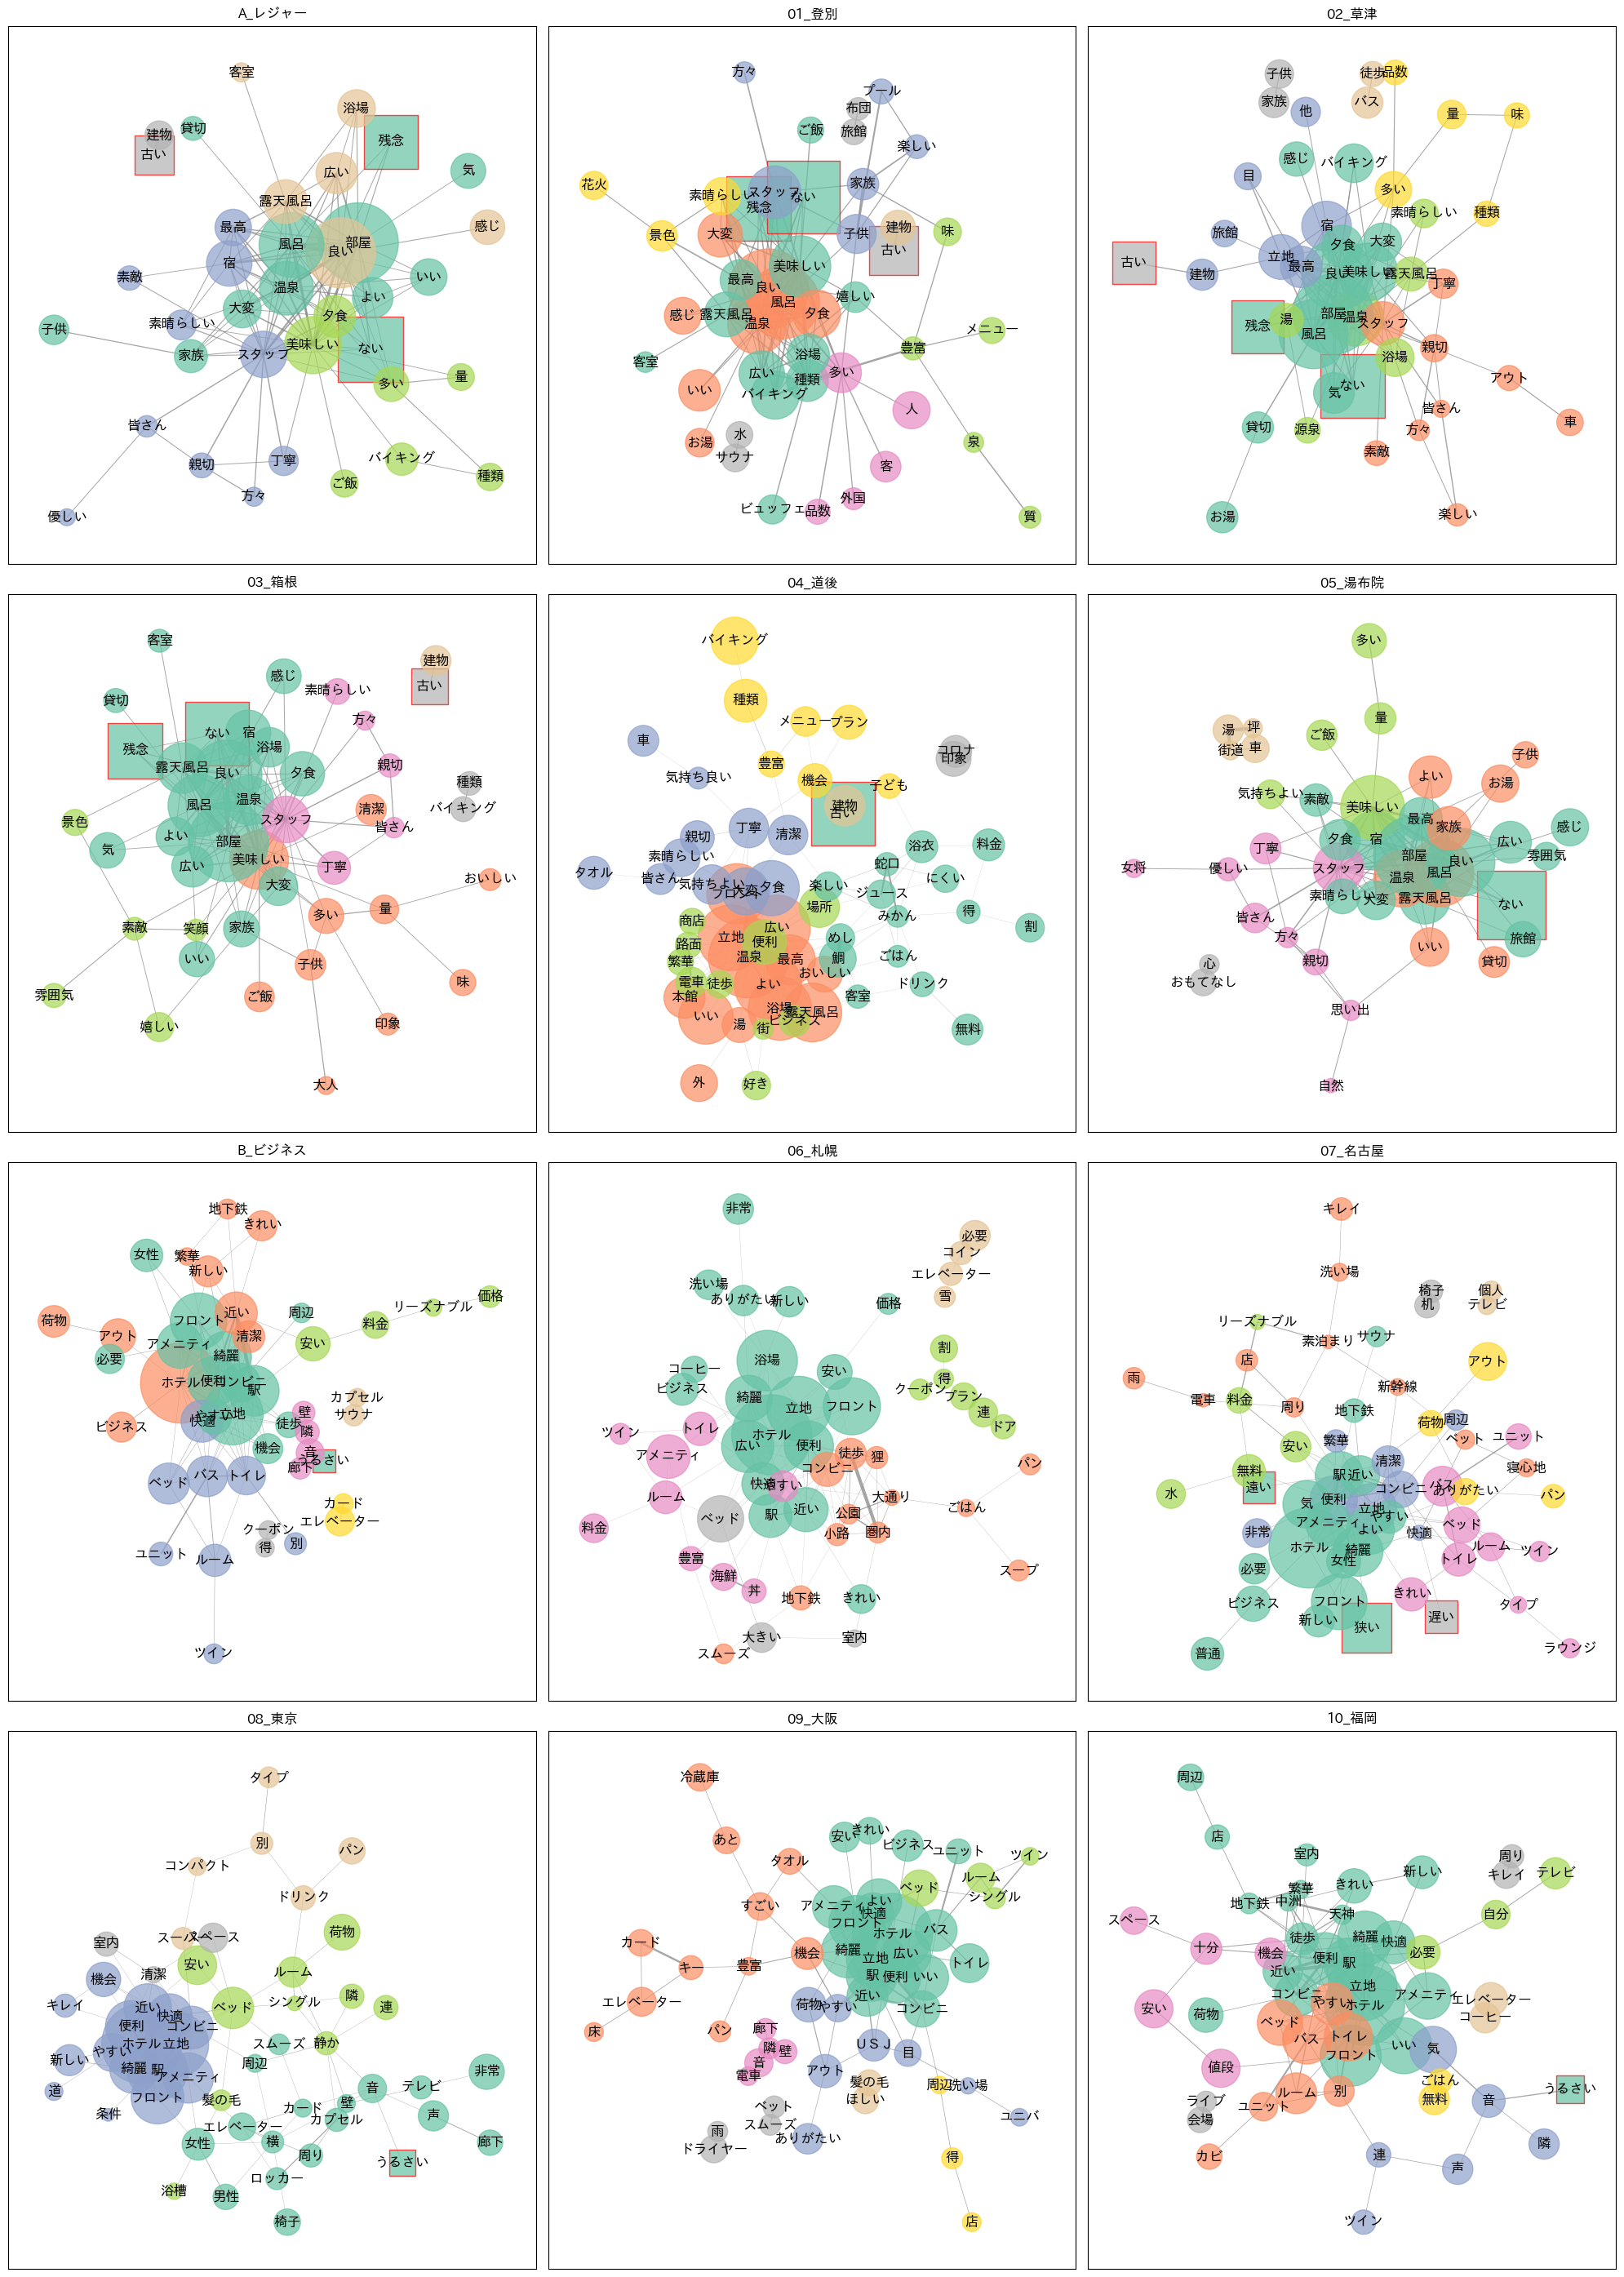

In [16]:
# 必要ライブラリのインポート
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# コーディングルール
coding_or = coding_neg

# サブルーチン
def sort_and_plot(name, group):

    # 「カテゴリー」ごとに Jaccard 係数でソートする
    sorted_columns = np.argsort(jaccard_attrs_df.loc[name].values)[::-1][:75]

    # Jaccard 係数Top 75語をソートして抽出する
    group_cross_df = group.iloc[:,sorted_columns]

    # 共起行列を作成する
    X = group_cross_df.values
    X = csc_matrix(X)
    Xc = (X.T * X)
    Xc = np.triu(Xc.toarray())

    # コーディングルールで絞り込む
    index = docs_df['表層'].str.contains("|".join(coding_or))
    group_cross_df = group_cross_df[group_cross_df.index.get_level_values('文書ID').isin(docs_df.loc[index, '文書ID'])]

    # 共起行列を DataFrame に整える
    group_cooccur_df = pd.DataFrame(Xc, columns=group_cross_df.columns, index=group_cross_df.columns)

    # 共起行列の中身を Jaccard 係数に入れ替える
    group_jaccard_df = jaccard_coef(group_cooccur_df, group_cross_df)

    # 抽出語の出現回数を取得する
    word_counts = group_cross_df.sum(axis=0).values

    # プロットする
    ax = fig.add_subplot(4, 3, i+1)
    plot_cooccur_network_with_code_ax(ax, group_jaccard_df, word_counts, np.sort(group_jaccard_df.values.reshape(-1))[::-1][120], coding_or)
    ax.set_title(name)


# プロットの準備
fig = plt.figure(figsize=(20, 28))

i = 0
# カテゴリごとのループ
for name, group in cross_1000_df.groupby(level='カテゴリー'):
    # サブルーチンを呼ぶ
    sort_and_plot(name, group)
    i += 1

    # エリアごとのループ
    for sub_name, sub_group in group.groupby(level='エリア'):
        # サブルーチンを呼ぶ
        sort_and_plot(sub_name, sub_group)
        i += 1

# プロットの仕上げ
plt.tight_layout()
plt.show()

#### 1.2.3 本文の参照 (カテゴリーごと)

「登別」と「道後」で「すばらしい」という単語が含まれている口コミを表示する

In [19]:
# 検索条件
search_index = \
    all_df['エリア'].isin(['01_登別', '05_道後']) & \
    (all_df['コメント'].str.contains('素晴らしい') | all_df['コメント'].str.contains('すばらしい'))

# 検索する
result_df = all_df[search_index]

# DataFrame を表示する
print(result_df.shape)
display(result_df.head())

# CSV に保存する
result_df.to_csv("output-1.csv", header=True)

(52, 18)


カテゴリー    エリア    施設番号                    施設名  \
4    A_レジャー  01_登別   80732       登別カルルス温泉　湯元オロフレ荘   
75   A_レジャー  01_登別   14467      洞爺湖温泉　ホテルグランド　トーヤ   
81   A_レジャー  01_登別  139962  ザ　レイクビュー　ＴＯＹＡ　乃の風リゾート   
102  A_レジャー  01_登別  109022         心のリゾート　海の別邸ふる川   
116  A_レジャー  01_登別  149046          緑の風リゾート　きたゆざわ   

                                                  コメント  総合  サービス  立地  部屋  \
4    カルルス温泉郷の静かな立地、そして湯元の素晴らしい泉質、美味しいお料理、飾らない中にも親切な...   5     5   5   5   
75   スタッフさんの対応が大変良かったです。建物自体は古めだけど清掃が隅々までいき届いており、大変...   5     5   5   4   
81   娘の大学受験お疲れ様の家族旅行で、利用しました。展望露天風呂から、羊蹄山がバーンと見えて、圧...   4     4   5   4   
102                                  料理、風呂、部屋とても素晴らしい。   5     5   5   5   
116  3度目の宿泊、いつもながら素晴らしいの一言。スタッフ、食事、部屋、温泉全て最高です。スタッフ...   5     5   5   5   

     設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月  投稿者  年代  性別  
4         5.0  5.0  5.0  レジャー  家族  44986  投稿者  na  na  
75        4.0  4.0  5.0  レジャー  家族  44774  投稿者  na  na  
81        4.0  5.0  4.0  レジャー  家族  44958  投稿者  na  na  
102       5.0  5.0  5.0  レジャー  一人  44743  投稿者  na  na  
116       5.0  5.0  5.0  レジャー  家族  44743  投稿者  na  na

「東京」と「福岡」で「うるさい」という単語が含まれている口コミを表示する

In [20]:
# 検索条件
search_index = \
    all_df['エリア'].isin(['08_東京', '10_福岡']) & \
    all_df['コメント'].str.contains('うるさい')

# 検索する
result_df = all_df[search_index]

# DataFrame を表示する
print(result_df.shape)
display(result_df.head())

# CSV に保存する
result_df.to_csv("output-2.csv", header=True)

(8, 18)


カテゴリー    エリア    施設番号                      施設名  \
7071  B_ビジネス  08_東京  137984            アゴーラプレイス　東京浅草   
7180  B_ビジネス  08_東京    5587                  ホテルリンクス   
7577  B_ビジネス  08_東京    1746  ｔｈｅ　ｂ　三軒茶屋（ザビー　さんげんぢゃや）   
9169  B_ビジネス  10_福岡   17701              博多グリーンホテル天神   
9592  B_ビジネス  10_福岡  167058            静鉄ホテルプレジオ博多駅前   

                                                   コメント  総合  サービス  立地  部屋  \
7071  連泊プランなのにタオルetc.の補充分をフロントで受け取る際に何度も確認され、すごく時間が掛...   3     2   4   3   
7180                   Wi-Fiが全く繋がらなくて困りました。暖房の音がうるさいです。   3     3   3   3   
7577               分かりづらい部屋もエレベーターもその他全般狭い建物もへ古いからかうるさい   2     3   2   1   
9169  何度か宿泊しています。ちょっと設備が古くなってきた感はありますが、必要な物は揃っています。な...   4     4   5   2   
9592     電車の音が少しうるさいけど、快適に過ごせます。敷地内で、福岡市のレンタサイクルも借りれます。   5     4   4   4   

      設備・アメニティ   風呂   食事 旅行の目的 同伴者   宿泊年月         投稿者   年代  性別  
7071       2.0  2.0  NaN   その他  家族  44805         投稿者   na  na  
7180       3.0  3.0  3.0  ビジネス  一人  44927  Tom Bradry  60代  男性  
7577       3.0  1.0  NaN  ビジネス  一人  44713      うしおちゃん  40代  女性  
9169       4.0  NaN  NaN  レジャー  一人  45047     sadstar  40代  女性  
9592       5.0  5.0  5.0  ビジネス  一人  44562         投稿者   na  na